# Loan status prediction:

#### Competition link : <a href = https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/> Loan prediction practcise problem </a>

##### Steps:
1) Data cleaning and preprocessing<br>
 2) EDA<br>
<b> 3) Creating and testing models </b> <br>
<b> 4) Model explanation </b>

## 3) Creating and testing models

In [1]:
# Import necessary modules and datasets

import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline as pl
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, truncnorm, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train_preprocessed.csv")

train_x = train.drop(["Loan_ID", "Loan_Status"], axis = 1)
train_y = train["Loan_Status"]

In [27]:
# K-fold train test splits of the data
rkf = RepeatedKFold(n_splits=4, n_repeats=3, random_state=8)

In [4]:
# Function to evaluate one model with cross validation
def evaluate_model(model, x = train_x, y = train_y, verbose = False):
    clf = clone(model)
    scores = cross_validate(clf, x, y, cv = rkf, scoring = ["accuracy", "roc_auc"])
    accuracy = scores["test_accuracy"].mean()
    auc = scores["test_roc_auc"].mean()
    if verbose:
        print("""Accuracy = {}\nAUC = {}""".format(accuracy, auc))
    
    return accuracy, auc

<br> Now let's look at how some models perform on the train data.

In [5]:
models = [("logreg", LogisticRegression(random_state=42)),
         ("naive_bayes", GaussianNB()),
         ("svc", make_pipeline(StandardScaler(), SVC(random_state=42))),
         ("knn", make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1))),
         ("tree", DecisionTreeClassifier(random_state=42)),
         ("extra_tree", ExtraTreeClassifier(random_state=42)),
         ("rf", RandomForestClassifier(random_state=42, n_jobs=-1)),
         ("extra_rf", ExtraTreesClassifier(random_state=42, n_jobs=-1)),
         ("ada", AdaBoostClassifier(random_state=42)),
         ("gbclf", GradientBoostingClassifier(random_state=42)),
         ("hist_gbc", HistGradientBoostingClassifier(random_state=42)),
         ("xgbc", XGBClassifier(random_state = 42, n_jobs = -1)),
         ("lgbm", LGBMClassifier(random_state=42, n_jobs=-1)),
         ("cat", CatBoostClassifier(random_state=42, silent = True))]

In [92]:
model_scores = []
for model_tuple in tqdm(models):
    model_name = model_tuple[0]
    model = model_tuple[1]
    model_accuracy, model_auc = evaluate_model(model)
    model_scores.append([model_name, model_accuracy, model_auc])
    
model_scores_df = pd.DataFrame(model_scores, columns = ["model_name", "accuracy", "auc"]).set_index("model_name")

 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:23<00:11,  3.82s/it]

[15:53:39] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:53:40] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:26<00:06,  3.38s/it]

[15:53:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:00<00:00,  4.32s/it]


In [99]:
sorted_accuracy = model_scores_df.sort_values("accuracy")["accuracy"]
sorted_auc = model_scores_df.sort_values("auc")["auc"]

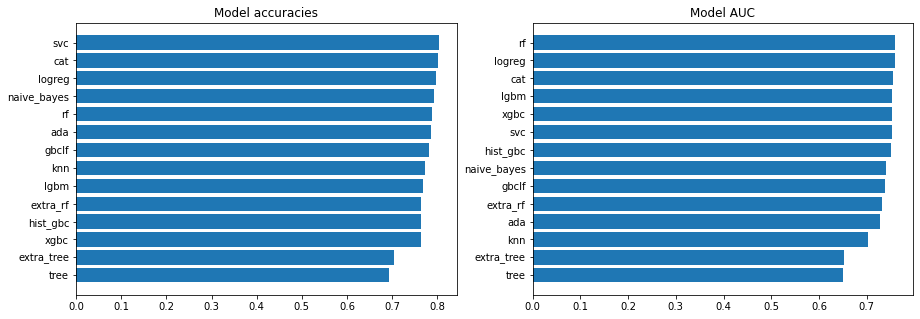

In [106]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].barh(sorted_accuracy.index, sorted_accuracy.values)
ax[0].set_title("Model accuracies")
ax[1].barh(sorted_auc.index, sorted_auc.values)
ax[1].set_title("Model AUC")
plt.show()

<br>All models except decision tree perform well on the train data. 

Lets look at the confusion matrix of predictions made by catboost. As the target classes are imbalnced, we need to check if the model is biased in favour of the majority class.

In [6]:
def get_clf_report(model = CatBoostClassifier(random_state=42, silent = True), x = train_x, y = train_y):
    clf = clone(model)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 456)
    
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    print("Confusion matrix : ")
    plot_confusion_matrix(clf, x_test, y_test, cmap = "Blues")
    plt.show()
    print("Classification report : ")
    print(classification_report(y_true=y_test, y_pred=preds))

Confusion matrix : 


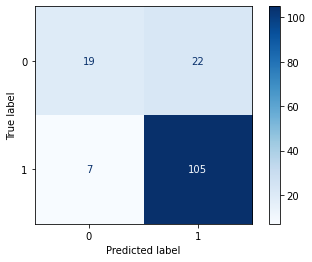

Classification report : 
              precision    recall  f1-score   support

           0       0.73      0.46      0.57        41
           1       0.83      0.94      0.88       112

    accuracy                           0.81       153
   macro avg       0.78      0.70      0.72       153
weighted avg       0.80      0.81      0.80       153



In [175]:
get_clf_report()

<br> As we can see, the model is in fact favouring the majority class. Lets oversample the minority class and see.
imblearn SMOTENC function is a very good choice to resample the data, as it can handle categorical variables.

In [8]:
categ_feats = [0,1,2,3,4,5,6,7,8,13,14,15,16]

Confusion matrix : 


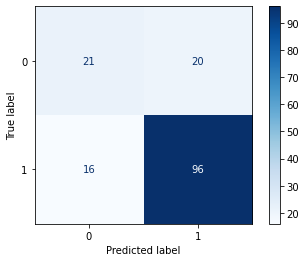

Classification report : 
              precision    recall  f1-score   support

           0       0.57      0.51      0.54        41
           1       0.83      0.86      0.84       112

    accuracy                           0.76       153
   macro avg       0.70      0.68      0.69       153
weighted avg       0.76      0.76      0.76       153



In [391]:
get_clf_report(model=pl(SMOTENC(categorical_features=categ_feats, random_state=3),CatBoostClassifier(random_state=42, silent = True)))

<br> Oversampling reduces the model bias, but increases variance, thus reducing accuracy.

Let's see if we can improve the accuracy by ensembling methods.

In [450]:
voting = VotingClassifier([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1)),
                            ("nb", GaussianNB()),
                            ("svc", make_pipeline(StandardScaler(), SVC(random_state=42))),
                            ("ada", AdaBoostClassifier(random_state=42)),
                            ("xgbc", XGBClassifier(random_state = 42, n_jobs= -1))
                          ],
                          voting = "hard")

[20:23:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix : 


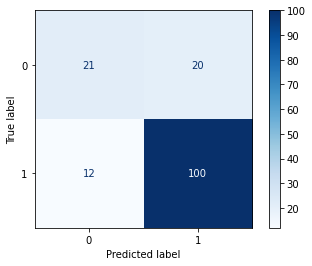

Classification report : 
              precision    recall  f1-score   support

           0       0.64      0.51      0.57        41
           1       0.83      0.89      0.86       112

    accuracy                           0.79       153
   macro avg       0.73      0.70      0.71       153
weighted avg       0.78      0.79      0.78       153



In [451]:
get_clf_report(model = pl(SMOTENC(categorical_features=categ_feats, random_state=3), voting))

<br> There is some improvement. Now let's try stacking classifier.

In [29]:
stacking = StackingClassifier([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1)),
                            ("nb", GaussianNB()),
                            ("svc", make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))),
                            ("ada", AdaBoostClassifier(random_state=42)),
                            ("xgbc", XGBClassifier(random_state = 42, n_jobs= -1)),
#     ("logreg", LogisticRegression(random_state=42)),
#              ("knn", make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1))),
#                           ("cat", CatBoostClassifier(random_state=42, silent = True))
                            ],
                          final_estimator=GaussianNB(), passthrough = False, stack_method="predict_proba",n_jobs = -1)

Confusion matrix : 


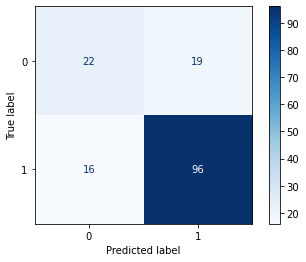

Classification report : 
              precision    recall  f1-score   support

           0       0.58      0.54      0.56        41
           1       0.83      0.86      0.85       112

    accuracy                           0.77       153
   macro avg       0.71      0.70      0.70       153
weighted avg       0.77      0.77      0.77       153



In [468]:
get_clf_report(model = pl(SMOTENC(categorical_features=categ_feats, random_state=3), stacking))

<br> Stack ensembling gives a bit better precision and recall for class 0 with a little less accuracy

## 4) Model explanation

(Shapley values.) <br>
Let's look at how each feature affects the model prediction. shap is a great package for that.

In [30]:
x_smote, y_smote = SMOTENC(categorical_features=categ_feats, random_state=125).fit_resample(train_x, train_y)
stacking_clf = clone(stacking)
stack_fit = stacking_clf.fit(x_smote, y_smote)


In [482]:
X100 = shap.utils.sample(x_smote, 100)
explainer = shap.Explainer(stacking_clf.predict, X100)
shap_values = explainer(x_smote)

Permutation explainer: 839it [58:12,  4.17s/it]                                                                        


AttributeError: 'Permutation' object has no attribute 'expected_value'

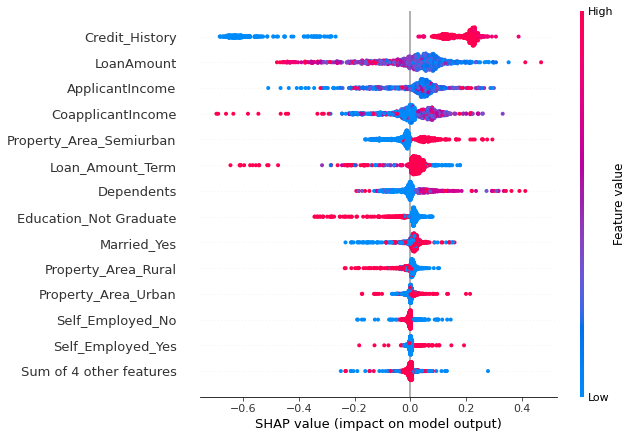

In [483]:
shap.plots.beeswarm(shap_values, max_display=14)

<br> From the above plot, Credit_history is the most important feature and has a positive correlation with target. (Credit_history = 1 implies Loan_Status = 1 i.e. loan approved). <br>
Next important feature is loan amount which is inversely correlated with the target, meaning higher loan amounts tend to result in loan being denied.

This plot tells us how each feature affects the outcome of the model trained on this particular limited data. 